# Plot Contact Map

### Import Modules

In [1]:
import os
import sys
import csv
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

cwd = os.getcwd()
parent_dir = f"{cwd}/../.."
sys.path.insert(1, parent_dir)

import chromo.util.rediscretize as rd
import chromo.fields as fd

### User Inputs

In [2]:
### UPDATE THIS CODE BLOCK ###
sim_id = 2
os.chdir(f"{parent_dir}/output/sim_{sim_id}")
output_prefix = "Chr_refine"
n_equilibrate = 120
field_path = "UniformDensityField"
cg_factor = 100     # 100 or 50 works well for refined; 5 works well for CG

# To plot the contact map of a specific snapshot, specify below
specific_snap = False
specific_snap_ind = 0

### Load Field Parameters

In [3]:
field_params = pd.read_csv(field_path, header=None, names=["Attribute", "Value"], index_col=0)
x_width = float(field_params.loc["x_width", "Value"])
y_width = float(field_params.loc["y_width", "Value"])
z_width = float(field_params.loc["z_width", "Value"])
nx = int(field_params.loc["nx", "Value"])
ny = int(field_params.loc["ny", "Value"])
nz = int(field_params.loc["nz", "Value"])

### Reduce Grid Resolution to Capture Longer-Range Contacts

In [4]:
nx = round(nx / 7.5)     # 7.5 works well for refined; 3 works well for CG
ny = round(ny / 7.5)     # 7.5 works well for refined; 3 works well for CG
nz = round(nz / 7.5)     # 7.5 works well for refined; 3 works well for CG
n_bins = nx * ny * nz

### Load Configurations and Generate Contact Map

In [5]:
files = os.listdir()
snapshots = [file for file in files if file.startswith(output_prefix) and file.endswith(".csv")]
snap_inds = [int(snap.split("-")[-1].split(".")[0]) for snap in snapshots]
snapshots = [snap for _, snap in sorted(zip(snap_inds, snapshots))]
snap_inds = np.sort(snap_inds)

if not specific_snap:
    snapshots_filtered = [snapshots[i] for i in range(len(snapshots)) if snap_inds[i] > n_equilibrate]
else:
    snapshots_filtered = [snapshots[i] for i in range(len(snapshots)) if snap_inds[i] == specific_snap_ind]

n_snapshots = len(snapshots_filtered)
weight = 1 / n_snapshots * cg_factor

In [6]:
for i, snap in enumerate(snapshots_filtered):
    
    print(f"Snap: {snap}")
    
    r = pd.read_csv(snap, usecols=[1, 2, 3], skiprows=[0, 1], header=None).to_numpy()
    
    if i == 0:
        n_beads_full_res = len(r)
        group_intervals = rd.get_cg_bead_intervals(n_beads_full_res, cg_factor)
        n_beads_cg = len(group_intervals)
        contact_map = np.zeros((n_beads_cg, n_beads_cg), dtype=float)
        nbr_bins = fd.get_neighboring_bins(nx, ny, nz)
        
    r_cg = rd.get_avg_in_intervals(r, group_intervals)

    bin_map = fd.assign_beads_to_bins(
        np.ascontiguousarray(r_cg), n_beads_cg, nx, ny, nz, x_width, y_width, z_width
    )
    
    for j in range(n_bins):
        
        # if (j+1) % 1000 == 0:
        #     print(f"Bin {j+1} of {n_bins}")
        
        for k in nbr_bins[j]:
            
            # Do not double-count neighbors 
            if k < j:
                continue

            for ind0 in bin_map[j]:
                for ind1 in bin_map[k]:
                    contact_map[ind0, ind1] += weight
                    contact_map[ind1, ind0] += weight


Snap: Chr_refine-121.csv
Snap: Chr_refine-122.csv
Snap: Chr_refine-123.csv
Snap: Chr_refine-124.csv
Snap: Chr_refine-125.csv
Snap: Chr_refine-126.csv
Snap: Chr_refine-127.csv
Snap: Chr_refine-128.csv
Snap: Chr_refine-129.csv
Snap: Chr_refine-130.csv
Snap: Chr_refine-131.csv
Snap: Chr_refine-132.csv
Snap: Chr_refine-133.csv
Snap: Chr_refine-134.csv
Snap: Chr_refine-135.csv
Snap: Chr_refine-136.csv
Snap: Chr_refine-137.csv


In [7]:
log_contacts = np.log10(contact_map+1)

### Save Contact Matrix

In [8]:
# np.savetxt("contact_matrix_single_sim.csv", contact_map, delimiter=",")

### Plot Contact Map

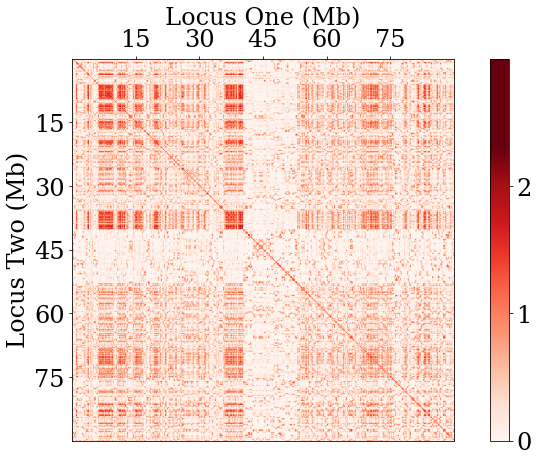

In [9]:
font = {'family' : 'serif',
        'weight':'normal',
        'size': 24}
plt.rc('font', **font)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.5)

extents = [0, 90, 90, 0]
im = ax.imshow(log_contacts, cmap="Reds", extent=extents)
ax.set_xticks([15, 30, 45, 60, 75])
ax.set_yticks([15, 30, 45, 60, 75])

# Color Bar
ticks = np.arange(0, np.ceil(np.max(log_contacts)), 1)
boundaries = np.linspace(0, np.ceil(np.max(log_contacts)), 1000)

ax.set_xlabel("Locus One (Mb)")
ax.set_ylabel("Locus Two (Mb)")
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()

fig.colorbar(im, cax=cax, orientation='vertical', ticks=ticks, boundaries=boundaries)
plt.tight_layout()
plt.savefig("contact_matrix_single_sim.png", dpi=600)

### Replicate MacPherson Figure

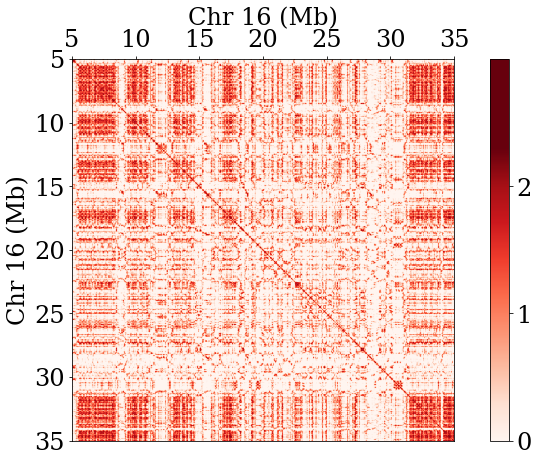

In [10]:
font = {'family' : 'serif',
        'weight':'normal',
        'size': 24}
plt.rc('font', **font)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.5)

extents = [5, 35, 35, 5]
im = ax.imshow(log_contacts[250:1750, 250:1750], cmap="Reds", extent=extents)
ax.set_xticks([5, 10, 15, 20, 25, 30, 35])
ax.set_yticks([5, 10, 15, 20, 25, 30, 35])

# Color Bar
ticks = np.arange(0, np.ceil(np.max(log_contacts)), 1)
boundaries = np.linspace(0, np.ceil(np.max(log_contacts)), 1000)

ax.set_xlabel("Chr 16 (Mb)")
ax.set_ylabel("Chr 16 (Mb)")
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()

fig.colorbar(im, cax=cax, orientation='vertical', ticks=ticks, boundaries=boundaries)
plt.tight_layout()
plt.savefig("contact_matrix_single_sim_MacPherson.png", dpi=600)